# Building Intensity Profile
The purpose of this notebook is to explore methods for determining the initial and final field magnitudes for ray tracing.

Considerations are the sampling requirements at the initial ray plane compared to the final ray plane. I do not think there is a restriction on matching the initial and final grid size by the *bin* size should remain constant.

In implementing this method the ray density per *bin* is proportional to the field strength. To determine the initial ray density, we could sample the number of rays per *bin* by sampling from the desired PDF, i.e. Gaussain.

Ideally, we would not have to rely on the ray density rather each ray would have a wieghting and then the final magnitude, sum of wieghts, in each bin would be proportional to the field strength.

Since now we are considering the bin values, we must also consider the propagation grid spacing, $dx$. This will require changing how rays are initiated. Each type of initial field will have a different distribution of rays or weights.

## Uniform Sampling
First consider a uniform initial beam, or flat top beam profile. The desired distribution of rays will be $1:1$ for each bin. In addition we should place the rays at the bin centers, that way when using *np.histogram* to count it will not be on a bin edge (atleast initially). 

In [1]:
import numpy as np
import model_tools.raytrace as rt
import model_tools.propagation as pt
import matplotlib.pyplot as plt
from pathlib import Path
import time

# Propagation constants|
wl = 0.000561
ko = 2 * np.pi / wl
x_max = 0.500
x_padding = 0.050
z_max = 0.1

dz = 0.001
dx = wl/2
n_xy = int(x_max // dx)
n_zx = int(z_max // dz)
# enforce odd grid numbers
if n_xy%2 == 0:
    n_xy += 1
if n_zx%2 == 0:
    n_zx += 1

# Create field grid to interpolate ray tracing results
focus_field_params = pt.field_grid(num_xy=n_xy,
                                     num_zx=1,
                                     dx=dx,
                                     dz=dz,
                                     return_field=False
                                     )
x, radius_xy = focus_field_params[0:2]

rays_params = {"type":"gaussian",
               "source":"infinity",
               "n_rays":3e6,
               "diameter":10,
               "sampling_limit":5
               }


ac508_150_a = rt.Doublet_lens(z1=155,
                              r1=83.2,
                              t1=12.0,
                              ri1=1.5214,
                              r2=-72.1,
                              t2=3.0,
                              ri2=1.6848,
                              r3=-247.7,
                              aperture_radius=(50.8/2),
                              ri_in=1.0, ri_out=1.0)
ac508_150_a.label="ac508-150-A"


Now we ray trace through the lens and some. Then reaquire the histogram. The new grid to pass into bins will be the array defining the propagation grid. This is determined by the beam size and sampling period $dx$.

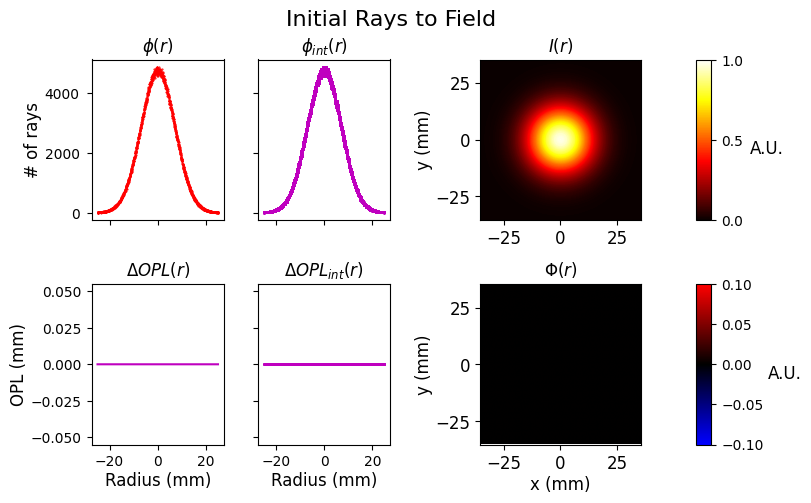

Ray tracing 3000000 rays takes 0.03 minutes


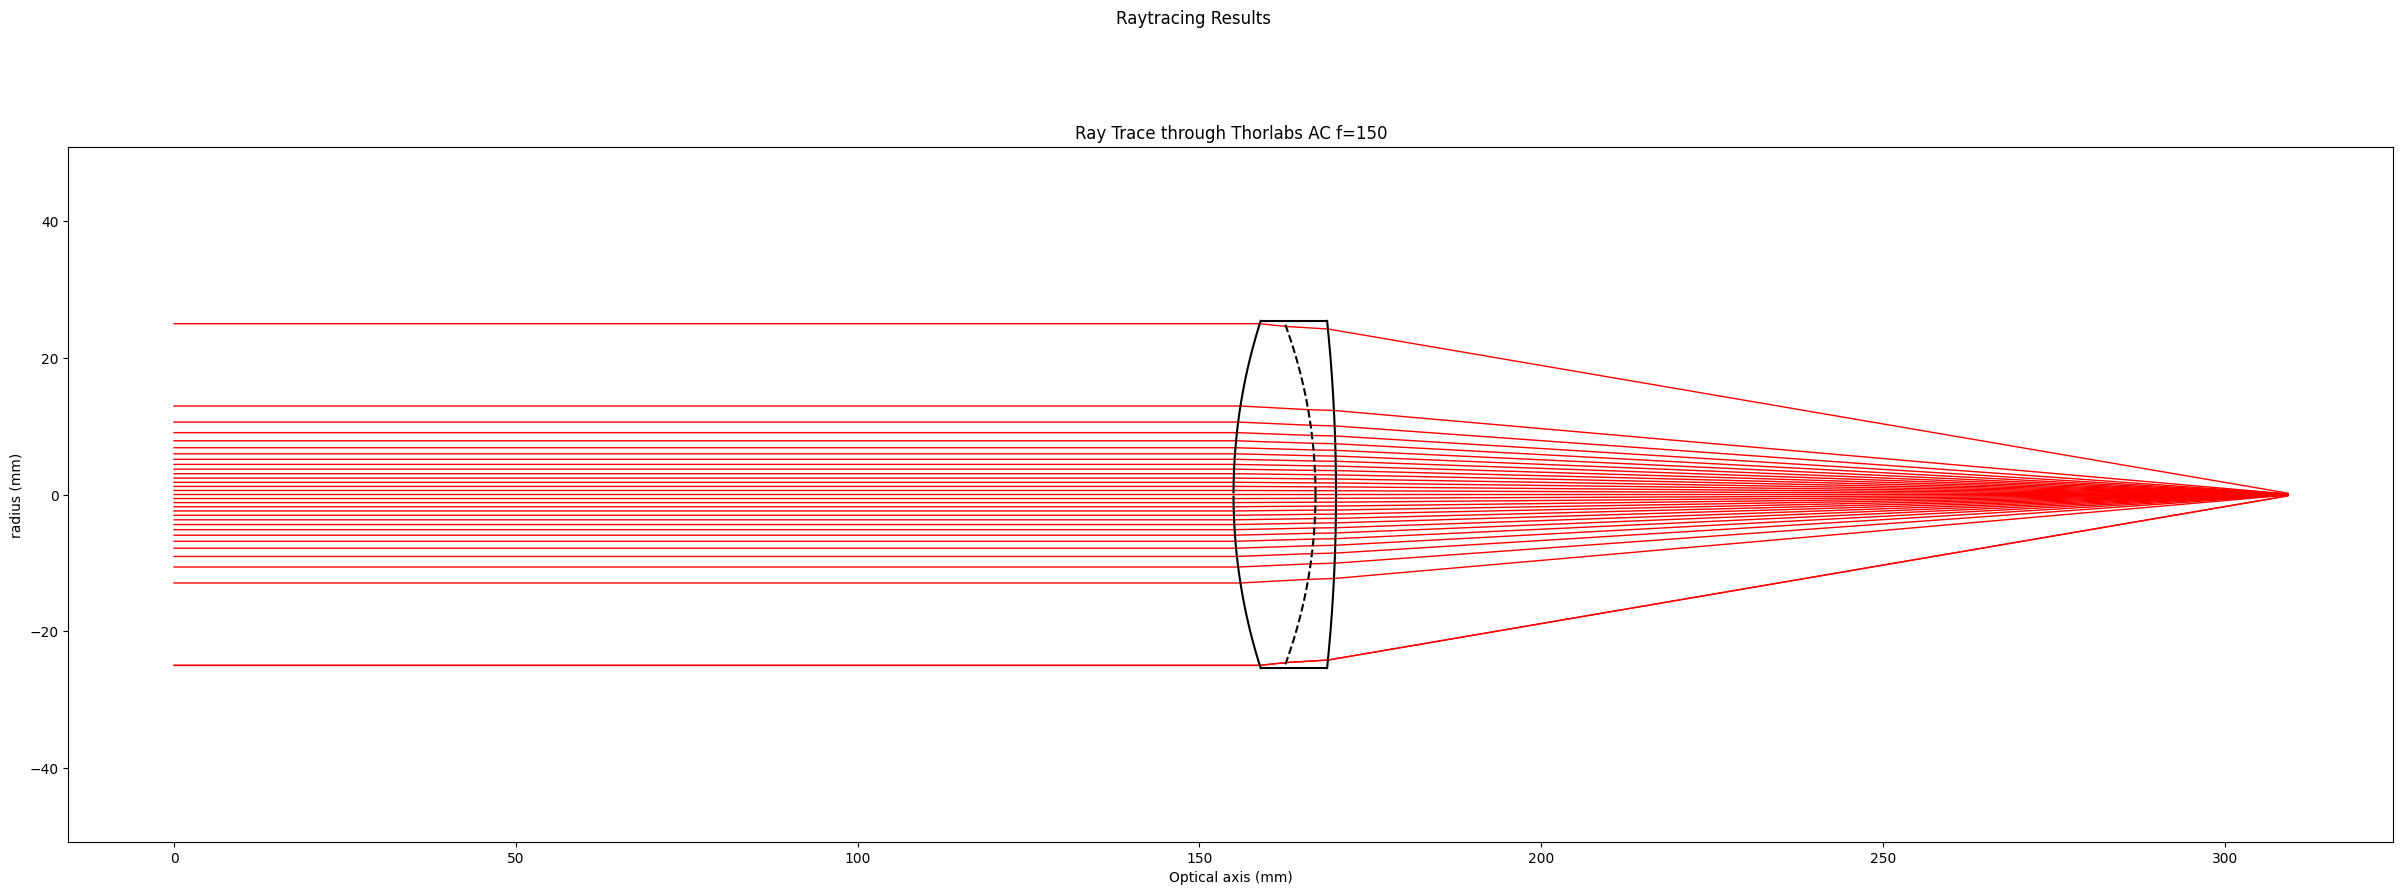

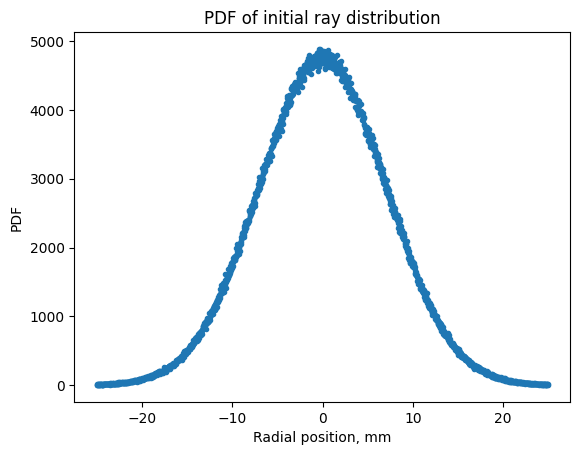

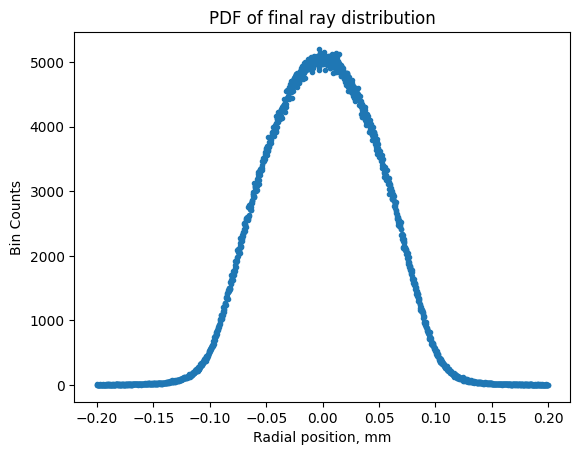

In [2]:
rays = rt.create_rays(*rays_params.values())
n_rays = rays.shape[1]

initial_field_params = pt.field_grid(num_xy=n_xy,
                                     num_zx=1,
                                     dx=50/n_xy,
                                     dz=dz,
                                     return_field=False
                                     )
x_i, radius_xy_i = initial_field_params[0:2]
field = rt.rays_to_field(mask_radius=radius_xy_i,
                        rays=rays.copy(),
                        ko=2 * np.pi / wl,
                        amp_binning=n_xy,
                        amp_type=None,
                        phase_type="opld",
                        results="field",
                        plot_field=True,
                        title="Initial Rays to Field",
                        save_path=Path(r"C:\Users\Steven\Documents\qi2lab\github\SPIM_model\data") / Path("field.png"),
                        showfig=True)
# Ray trace
start = time.time()
rays = ac508_150_a.raytrace(rays)
rays_to_field_plane = rt.rays_to_field_plane(rays, x_max=np.max(x), padding=x_padding)
rays = rt.intersect_plane(rays, rays_to_field_plane, ri_in=1.0, refract=False)
end = time.time()
print('Ray tracing %d rays takes %.2f minutes' % (n_rays, ((end-start)/60)))

rt.plot_rays(rays.copy(),
             n_rays_to_plot=31,
             optical_train=[ac508_150_a],
             title='Ray Trace through Thorlabs AC f=150',
             save_path=None,
             showfig=True)

# Plot initial ray distribution
hist, bin_edges = np.histogram(rays[0, :, 0], bins=n_xy, density=False)
plt.figure()
plt.title('PDF of initial ray distribution')
plt.plot(bin_edges[:-1], hist, '.')
# plt.ylim((0, 1))
plt.xlabel('Radial position, mm')
plt.ylabel('PDF')
plt.show()

# Plot final ray distribution
nan_mask = np.logical_not(np.isnan(rays[-1, :, 0]))
max_radius = np.max(rays[-1, :, 0][nan_mask])
hist, bin_edges = np.histogram(rays[-1, :, 0][nan_mask], bins=n_xy, density=False)
plt.figure()
plt.title('PDF of final ray distribution')
plt.plot(bin_edges[:-1], hist, '.')
plt.xlabel('Radial position, mm')
plt.ylabel('Bin Counts')
plt.show()

## Convert to field strength
Next would be to relate the number of rays per bin to the field magnitude. 
If the proportionality holds true then the number of counts should be a good enough measure of the field magnitude, though it lacks any physical units.

Now to build the amplitude array, we would want the number of bins to be equal to the number of grid points minus one. There are currently three methods:
1. Interpolate on grid based on ray bin counts.
2. Scale interpolated result by a constant factor.
3. Normalize interpolated result with respect to bin counts.

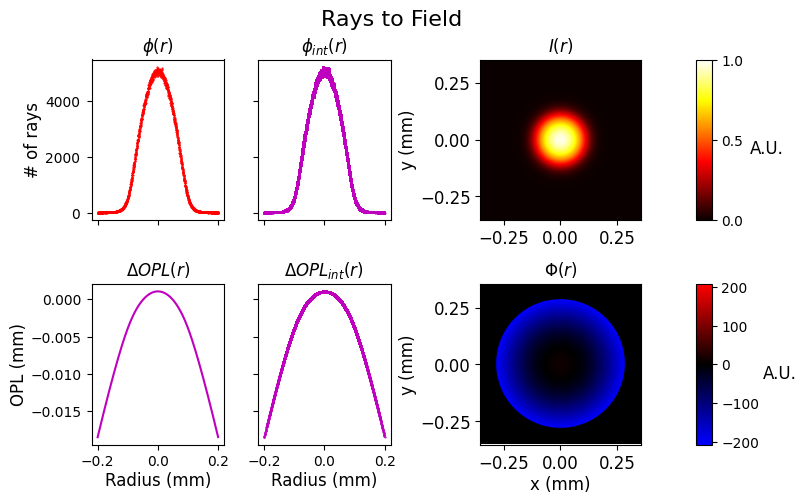

In [3]:
field = rt.rays_to_field(mask_radius=radius_xy,
                rays=rays.copy(),
                ko=2 * np.pi / wl,
                amp_binning=n_xy,
                amp_type=None,
                phase_type="opld",
                results="field",
                plot_field=True,
                title="Rays to Field",
                save_path=Path(r"C:\Users\Steven\Documents\qi2lab\github\SPIM_model\data") / Path("field.png"),
                showfig=True)

# amp = np.abs(field)
# rt.plot_radial_distribution(rays.copy(),
#                             binning=n_xy,
#                             title = "Ray Distribution",
#                             save_path = None,
#                             showfig = True)


In [ ]:
# Build phase profile
# unit conversions from um
mm = 1e3
nm = 1e-3

# Model parameters
wl = 0.561 / mm
NA = 0.14
Io = 1
ri = 1.0
ko = 2 * np.pi / wl

# Calculate path length difference
#n_rays = len(rays[-1])
opld = rays[-1, :, 3] - rays[-1, n_rays//2, 3]

# Interpolate path length difference
opld_interp = rt.interp1d(rays[-1, :, 0], opld, fill_value='extrapolate')

# Fit wavefront curvature
wf_curvature, fit_params, fit_cov = rt.fit_opl(rays[-1, :, 0], rays[-1, :, 3])
print('wavefront curvature: %.2f' % wf_curvature)

print('Creating phase profile from opl calculations...')
start_phasemask = time.time()

phase = pt.create_phase_mask(mask, mask_params['radius_xz'], ko, opld_interp)

stop_phasemask = time.time()
print('Time to create phase mask %.2f minutes' % ((stop_phasemask-start_phasemask)/60))

theory = amp * phase

rt.plot_field(theory,
                extent_real=mask_params['extent_xz'], extent_kspace=mask_params['extent_kxkz'],
                title=r'Test field near focus, no propagation',
                units=r'mm', savefig=False)
                    # Test propogate

In [ ]:
# Test propogation
x = mask_params['x_array']
field = pt.propagate(theory, wl, abs(x[1]-x[0]), -wf_curvature, ri)

rt.plot_field(field,
                extent_real=mask_params['extent_xz'], extent_kspace=mask_params['extent_kxkz'],
                title=r'Propagated to focus, dy=%.2f' % -wf_curvature,
                units=r'mm', savefig=True)

In [ ]:
field = pt.propagate(theory, wl, abs(x[1]-x[0]), -2*wf_curvature, ri)

rt.plot_field(field,
                extent_real=mask_params['extent_xz'], extent_kspace=mask_params['extent_kxkz'],
                title=r'Propagated to other side of focus, dy=%.2f' % (-2*wf_curvature),
                units=r'mm', savefig=True)

In [ ]:
# Test with caustic profile
print('Starting propogation')
ymin, ymax = wf_curvature/2, -wf_curvature - wf_curvature/2
ny = 51
y = np.linspace(ymin, ymax, ny)
dy = y[1] - y[0]
extent_yx = [y[0] - dy/2, y[-1] + dy/2, x[0] - dx/2, x[-1] + dx/2]

field = np.zeros((ny, n_grid, n_grid), dtype=complex)

tstart_prop = time.perf_counter()
for ii in range(ny):
    print('propogated to slice: %d of %d in %0.2fs\r' %  (ii, (ny-1), time.perf_counter() - tstart_prop), end="")
    field[ii] = pt.propagate(theory, wl, dx, y[ii], ri)
print("")

print('calculating intensity and phase angles...')
intensity = np.abs(field)**2

print('Building caustic profiles')
caustic = np.abs(field[:, n_grid//2].transpose())**2


In [ ]:
# Plot caustic profile
ylim = 1
figh = plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 1,  1)
ax.set_title("Intensity, ZX plane, Gaussian Beam")
ax.imshow(caustic,
          cmap='hot',
          extent=extent_yx,
          origin="lower",
          aspect="auto",
         interpolation="none")
plt.tight_layout()
ax.set_xlabel(r"z-position ($mm$)")
ax.set_ylabel(r"x-position ($mm$)")
#ax.set_ylim([-ylim, ylim])
plt.show()
